In [25]:
# paquetes de la implementación
import numpy as np
import gym
import random

# paquetes de las gráficas
import matplotlib.pyplot as plt


In [26]:
# entorno
env = gym.make('MountainCar-v0')

In [27]:
"""
Como Mountain Car es tiene un espacio de obs continuo, es necesario discretizar
se aplica Tile coding para generar particiones del espacio de obs, teniendo dos variables : posición y velocidad
"""
num_particion  = 8
particiones_por_dim = (8, 8)
particiones_totales = num_particion * particiones_por_dim[0] * particiones_por_dim[1] 


In [28]:
# límites del estado 
pos_min, pos_max = -1.2, 0.6
vel_min, vel_max = -0.07, 0.07

In [ ]:
# hiperparámetros
pasos_totales = 0
lista_pasos = []         
lista_recompensas = []  

alpha = 0.1         # tasa de aprendizaje
gamma = 0.995       # descuento
epsilon = 0.1       # epsilon-greedy
n_planning = 5      # planeación
num_episodios = 2500


In [30]:
def get_particiones(estado):
    pos, vel = estado[0], estado[1]
    indices = []
    
    ancho_particion_pos = (pos_max - pos_min) / (particiones_por_dim[0] - 1)
    ancho_particion_vel = (vel_max - vel_min) / (particiones_por_dim[1] - 1)
    
    for pt in range(num_particion):
        
        offset_pos = (pt / num_particion) * ancho_particion_pos
        offset_vel = (pt / num_particion) * ancho_particion_vel
        
        
        i_pos = int((pos - pos_min + offset_pos) / ancho_particion_pos)
        i_vel = int((vel - vel_min + offset_vel) / ancho_particion_vel)
        
        
        i_pos = min(i_pos, particiones_por_dim[0] - 1)
        i_vel = min(i_vel, particiones_por_dim[1] - 1)
    
        
        ind_global = pt * (particiones_por_dim[0] * particiones_por_dim[1]) + i_pos * particiones_por_dim[1] + i_vel
        indices.append(ind_global)
    
    return tuple(indices)  

In [ ]:
# tabla Q 
Q = {}      
Model = {}  

def get_Q(estado_particiones, accion):
    key = (estado_particiones, accion)
    if key not in Q:
        Q[key] = 0.0
    return Q[key]

In [ ]:
def act_Q(estado_particiones, accion, td_error):
    key = (estado_particiones, accion)
    if key not in Q:
        Q[key] = 0.0
    Q[key] += alpha * td_error

In [ ]:
# entrenamiento
for episodio in range(num_episodios):
    estado_cont, _ = env.reset()  
    estado_particiones = get_particiones(estado_cont)
    terminado = False
    recompensa_total = 0

    while not terminado:
        # política
        if np.random.rand() < epsilon:
            accion = np.random.randint(3)  
        else:
            q_vals = [get_Q(estado_particiones, a) for a in range(3)]
            accion = int(np.argmax(q_vals))
        
        
        obs_sig, recompensa, done, truncated, _ = env.step(accion)
        terminado = done or truncated
        recompensa_total += recompensa
        pasos_totales += 1

        sig_estado_particiones = get_particiones(obs_sig)

        # actualizar Q 
        q_next = max([get_Q(sig_estado_particiones, a) for a in range(3)])
        td_error = recompensa + gamma * q_next - get_Q(estado_particiones, accion)
        act_Q(estado_particiones, accion, td_error)
        
        # luego el modelo
        Model[(estado_particiones, accion)] = (recompensa, sig_estado_particiones)
        
        # planeación
        if len(Model) > 0:
            for _ in range(n_planning):
                key_sim = random.choice(list(Model.keys()))
                r_sim, s_sim = Model[key_sim]
                a_sim = key_sim[1]
                q_sim_next = max([get_Q(s_sim, a) for a in range(3)])
                td_error_sim = r_sim + gamma * q_sim_next - get_Q(key_sim[0], a_sim)
                act_Q(key_sim[0], a_sim, td_error_sim)
        
        estado_particiones = sig_estado_particiones

    lista_recompensas.append(recompensa_total)
    lista_pasos.append(pasos_totales)

    if (episodio + 1) % 50 == 0:
        print(f"Episodio {episodio+1}, Recompensa = {recompensa_total}")

env.close()

In [ ]:
def promedio(datos, vnv=10): # vnv: para el promedio de los episodios
    return np.convolve(datos, np.ones(vnv)/vnv, mode='valid')

vnv = 10
recompensas_soft = promedio(lista_recompensas, vnv)
pasos_soft = lista_pasos[vnv-1:]  

In [ ]:
print("Gráfica de recompensa obtenida.")
print("Eje x: pasos")
print("Eje y : recompensa promedio")
plt.figure(figsize=(8,5))
plt.plot(pasos_soft, recompensas_soft, label=f"Recompensa Promedio")
plt.xlabel("Pasos Acumulados")
plt.ylabel("Recompensa Promedio")
plt.title("Entrenamiento (Dyna-Q)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# corrida sobre 10 experiementos
def eva_politica(env, Q, n_episodios=10):
    recompensas = []
    for _ in range(n_episodios):
        estado_cont, _ = env.reset()
        estado_particiones = get_particiones(estado_cont)
        terminado = False
        recompensa_total = 0
        while not terminado:
            
            q_vals = [get_Q(estado_particiones, a) for a in range(3)]
            accion = int(np.argmax(q_vals))
            obs_sig, recompensa, done, trunco, _ = env.step(accion)
            terminado = done or trunco
            recompensa_total += recompensa
            estado_particiones = get_particiones(obs_sig)
        recompensas.append(recompensa_total)
    return recompensas

C:\Users\ST\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episodio 50, Recompensa = -200.0
Episodio 100, Recompensa = -200.0
Episodio 150, Recompensa = -200.0
Episodio 200, Recompensa = -200.0
Episodio 250, Recompensa = -200.0
Episodio 300, Recompensa = -200.0
Episodio 350, Recompensa = -200.0
Episodio 400, Recompensa = -200.0
Episodio 450, Recompensa = -200.0
Episodio 500, Recompensa = -200.0
Episodio 550, Recompensa = -159.0
Episodio 600, Recompensa = -195.0
Episodio 650, Recompensa = -200.0
Episodio 700, Recompensa = -200.0
Episodio 750, Recompensa = -195.0
Episodio 800, Recompensa = -200.0
Episodio 850, Recompensa = -166.0
Episodio 900, Recompensa = -169.0
Episodio 950, Recompensa = -200.0
Episodio 1000, Recompensa = -156.0
Episodio 1050, Recompensa = -200.0
Episodio 1100, Recompensa = -200.0
Episodio 1150, Recompensa = -200.0
Episodio 1200, Recompensa = -200.0
Episodio 1250, Recompensa = -166.0
Episodio 1300, Recompensa = -200.0
Episodio 1350, Recompensa = -164.0
Episodio 1400, Recompensa = -172.0
Episodio 1450, Recompensa = -164.0
Episo

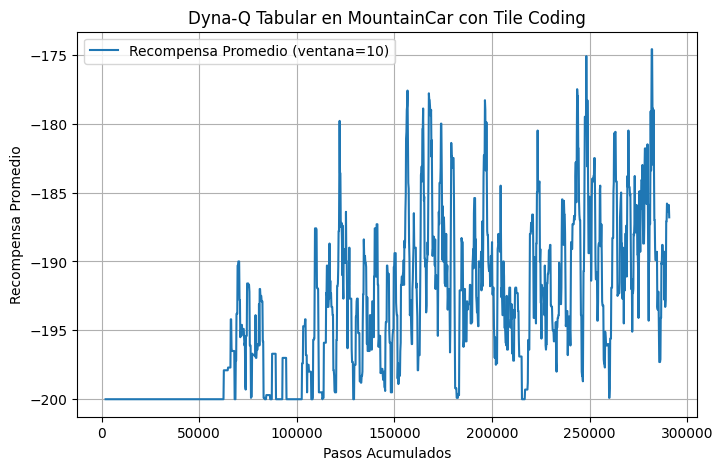


Resultados de la política final en 10 experimentos:
----------------------------------------------
| Métrica      | Valor                |
----------------------------------------------
| Media        | -180.60              |
| Desviación   | 17.44                |
----------------------------------------------


In [ ]:
# nuevo entorno para evaluación 
env_eval = gym.make("MountainCar-v0")
recompensas_eval = eva_politica(env_eval, Q, n_episodios=10)
env_eval.close()

media_recompensa = np.mean(recompensas_eval)
std_recompensa = np.std(recompensas_eval)

print("\nResultados de la política final en 10 experimentos:")
print("----------------------------------------------")
print(f"| {'Métrica':<12} | {'Valor':<20} |")
print("----------------------------------------------")
print(f"| {'Media':<12} | {media_recompensa:<20.2f} |")
print(f"| {'Desviación':<12} | {std_recompensa:<20.2f} |")
print("----------------------------------------------")
